In [1]:
# 1.) What was the change in price of the stock over time?
# 2.) What was the daily return of the stock on average?
# 3.) What was the moving average of the various stocks?
# 4.) What was the correlation between different stocks'?
# 5.) How much value do we put at risk by investing in a particular stock?
# 6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# Scale the data
from sklearn.preprocessing import MinMaxScaler

# Keras with the model
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #, root_mean_squared_error

# For time stamps
from datetime import datetime

# The tech stocks we'll use for this analysis
tech_list = ['AAPL']

end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL]
company_name = ["APPLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name


[*********************100%%**********************]  1 of 1 completed


In [3]:
# Get the stock quote
df = AAPL.copy() 

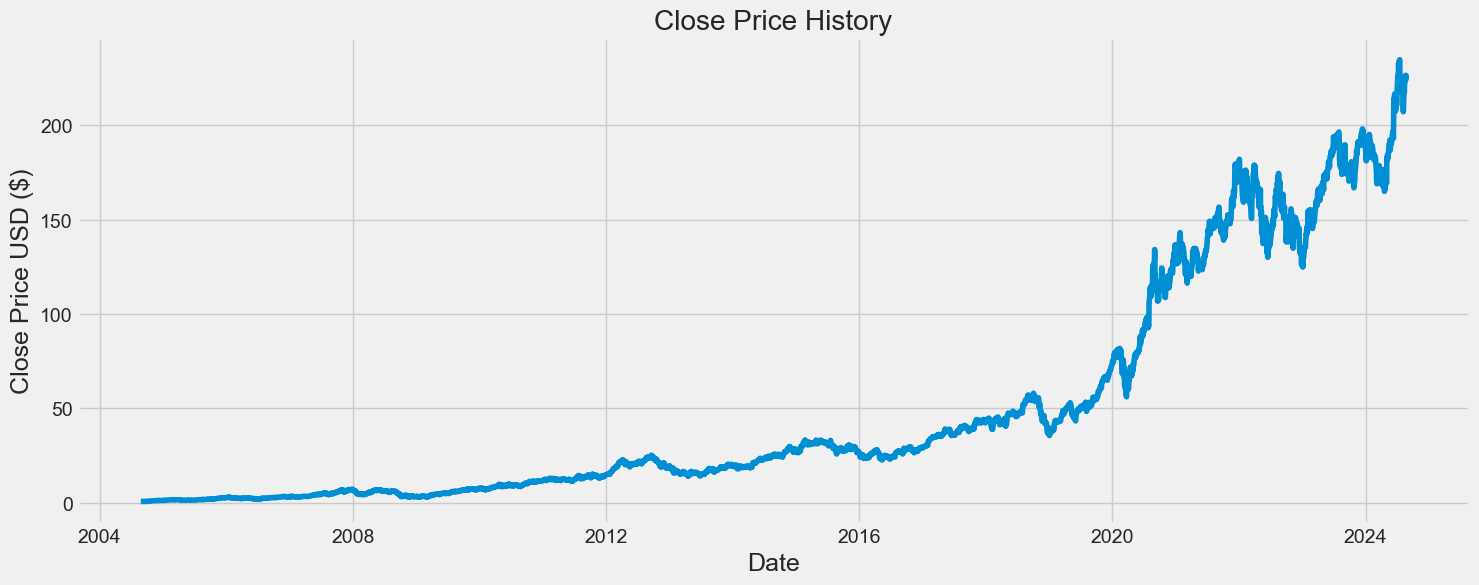

In [4]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close colum
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# x_train.shape

[array([4.11724032e-05, 1.75354844e-05, 0.00000000e+00, 2.82096226e-05,
       1.32662617e-04, 1.17415521e-04, 8.46288678e-05, 1.25037033e-04,
       1.70021974e-04, 1.20464075e-04, 1.33426855e-04, 1.12078579e-04,
       1.04452995e-04, 8.23402255e-05, 1.70021974e-04, 2.30254266e-04,
       2.73715057e-04, 2.96587483e-04, 2.13483019e-04, 2.40168238e-04,
       2.41692642e-04, 2.59992364e-04, 2.98876125e-04, 3.47669786e-04,
       3.53006728e-04, 3.46909874e-04, 3.56059608e-04, 4.00280566e-04,
       4.97107976e-04, 4.19340200e-04, 3.76643647e-04, 3.40808440e-04,
       3.17935759e-04, 4.29250100e-04, 8.28006516e-04, 8.67654515e-04,
       1.03920522e-03, 1.01404415e-03, 1.01785694e-03, 1.05368782e-03,
       1.01327991e-03, 1.02395405e-03, 1.05597647e-03, 1.23362402e-03,
       1.37772502e-03, 1.39373635e-03, 1.39754914e-03, 1.47760531e-03,
       1.61560919e-03, 1.55003563e-03, 1.57062400e-03, 1.54469869e-03,
       1.51954195e-03, 1.57291264e-03, 1.61484495e-03, 1.63009180e-03,
     

In [8]:
firstLayer = range(32, 256, 32)
secondLayer = range(32, 128, 32)
firstDensity = range(10, 50, 10)
secondDensity = range(1, 6, 2)

# epochs = range(1, 10, 1)
ep = 1

counter = 0

colums = ['Units firstLayer', 'Units SecondLayer','firstDensity', 'secondDensity', 'Epochs' , 'MSE', 'RMSE', 'MAE', 'R2']
results = pd.DataFrame(columns=colums)

for fl in firstLayer:
    for sl in secondLayer:
        for fd in firstDensity:
            # for sd in secondDensity:
            # for ep in epochs:
            # Build the LSTM model
            model = Sequential()
            model.add(LSTM(units=fl, return_sequences=True, input_shape=(x_train.shape[1], 1)))
            model.add(LSTM(units=sl, return_sequences=False))
            model.add(Dense(fd))
            model.add(Dense(1))

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            model.fit(x_train, y_train, batch_size=1, epochs=ep)

            # Create the testing data set
            # Create a new array containing scaled values from index 1543 to 2002 
            test_data = scaled_data[training_data_len - 60: , :]

            # Create the data sets x_test and y_test
            x_test = []
            y_test = dataset[training_data_len:, :]

            for i in range(60, len(test_data)):
                x_test.append(test_data[i-60:i, 0])

            # Convert the data to a numpy array
            x_test = np.array(x_test)

            # Reshape the data
            x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

            # Get the models predicted price values 
            predictions = model.predict(x_test)
            predictions = scaler.inverse_transform(predictions)

            # Assuming y_test are the actual values and y_pred are the predicted values
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
            #rmse = root_mean_squared_error(y_test, predictions)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
 
            results.loc[counter] = [fl,  sl, fd, 1, ep, mse, rmse, mae, r2]
            counter +=1
            print('counter',counter)


8/8 [==============================] - 1s 12ms/step
counter 1
8/8 [==============================] - 1s 12ms/step
counter 2
8/8 [==============================] - 1s 16ms/step
counter 3
8/8 [==============================] - 1s 12ms/step
counter 4
8/8 [==============================] - 1s 20ms/step
counter 5
8/8 [==============================] - 1s 18ms/step
counter 6
8/8 [==============================] - 1s 17ms/step
counter 7
8/8 [==============================] - 1s 19ms/step
counter 8
8/8 [==============================] - 1s 18ms/step
counter 9
8/8 [==============================] - 1s 14ms/step
counter 10
8/8 [==============================] - 1s 17ms/step
counter 11
8/8 [==============================] - 1s 17ms/step
counter 12
8/8 [==============================] - 1s 14ms/step
counter 13
8/8 [==============================] - 1s 19ms/step
counter 14
8/8 [==============================] - 1s 19ms/step
counter 15
8/8 [==============================] - 1s 15ms/step
counter 16
8

In [11]:
display(results)

,Units firstLayer,Units SecondLayer,firstDensity,secondDensity,Epochs,MSE,RMSE,MAE,R2
0,32.0,32.0,10.0,1.0,1.0,29.119337,5.396234,4.167361,0.906079
1,32.0,32.0,20.0,1.0,1.0,74.112152,8.608842,7.208851,0.760960
2,32.0,32.0,30.0,1.0,1.0,38.107960,6.173164,5.099031,0.877087
3,32.0,32.0,40.0,1.0,1.0,185.500397,13.619853,12.780970,0.401689
4,32.0,64.0,10.0,1.0,1.0,177.369087,13.317999,12.549368,0.427916
...,...,...,...,...,...,...,...,...,...
79,224.0,64.0,40.0,1.0,1.0,164.650304,12.831613,11.972832,0.468939
80,224.0,96.0,10.0,1.0,1.0,19.183431,4.379889,3.579826,0.938126
81,224.0,96.0,20.0,1.0,1.0,72.929099,8.539854,7.793940,0.764775
82,224.0,96.0,30.0,1.0,1.0,16.811178,4.100144,3.224977,0.945777


In [22]:
import os
import pickle

results.sort_values(by=['MSE','RMSE'] ).to_csv('results 20 years.csv', decimal=',')

# filename = "results.pkl"

# if not os.path.isfile(filename):
#    with open(filename,'wb') as file:
#        pickle.dump(results, file)
#    file.close()
